In [1]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd drive/MyDrive/datasets/

In [4]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [5]:
df_test['Tweet text'] = df_test['Tweet text'].apply(emoji.demojize)

In [6]:
def word_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith(("@", "#"))]
    return len(newlist)

def tag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("@")]
    return len(newlist)

def hashtag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("#")]
    return len(newlist)

def has_emoji(s):
    splitted = s.split()
    newlist = [x for x in splitted if x != ":" and x.startswith(":") and x.endswith(":")]
    return len(newlist)

def clean_text(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith((":", "@", "#"))]
    return ' '.join(newlist)

### dodani featuresi ###
def link_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith(('http:', 'https:'))]
    return len(newlist)

def smiley_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not re.match(r'([\:\;\=][\(\)PD]+)+', x)]
    return len(newlist)

def exclamation_mark_counter(s):
    return s.count('!')

In [7]:
df['length'] = df['Tweet text'].apply(len)
df['word_count'] = df['Tweet text'].apply(word_counter)
df['tag_count'] = df['Tweet text'].apply(tag_counter)
df['hashtag_count'] = df['Tweet text'].apply(hashtag_counter)
df['link_count'] = df['Tweet text'].apply(link_counter)
df['smiley_count'] = df['Tweet text'].apply(smiley_counter)
df['exclamation_mark_count'] = df['Tweet text'].apply(exclamation_mark_counter)
df['has_emoji'] = df['Tweet text'].apply(has_emoji)
df['clean_text'] = df['Tweet text'].apply(clean_text)

In [8]:
nlp = spacy.load("en_core_web_md") # treba instalirat ako nemate, s md cemo dobivat bolji performans a i dalje nije prevelik

In [9]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [10]:
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text
398,399,1,About to write my math final really excited #...,84,9,0,1,1,10,0,0,About to write my math final really excited ht...
2403,2407,0,Pretty sure there's a satanic baby in the apar...,134,21,0,1,0,22,0,0,Pretty sure there's a satanic baby in the apar...
2179,2183,0,[Alaska #HipHop] Flowtronics: What's This Worl...,133,15,1,1,1,17,0,0,[Alaska Flowtronics: What's This World Coming ...
3383,3398,1,People in this school seem to amaze me..,41,8,0,0,0,8,0,0,People in this school seem to amaze me..
50,51,1,It will be impossible for me to be late if I s...,101,17,0,3,0,20,0,0,It will be impossible for me to be late if I s...
...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1130,1,@Zoopla brilliant news for potential young buy...,51,6,1,0,0,7,1,0,brilliant news for potential young buyers!
1213,1214,1,I'm seeing more and more people using the term...,133,23,0,1,0,24,0,0,I'm seeing more and more people using the term...
490,491,1,I couldnt help myself.. I am a bad person... ...,68,10,0,0,1,10,0,0,I couldnt help myself.. I am a bad person... h...
1485,1486,0,My Com professor keeps talking about Twitter. ...,51,8,0,0,0,8,0,0,My Com professor keeps talking about Twitter. ...


## Preprocessing for classification

In [11]:
!pip install tweet-preprocessor

In [12]:
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY)
# tweet_text_train['clean text'] = tweet_text_train['Tweet text'].map(lambda x: p.clean(x))
# tweet_text_validation['clean text'] = tweet_text_validation['Tweet text'].map(lambda x: p.clean(x))

In [13]:
# tweet_text_train.head()

In [14]:
# for i in tweet_text_train.index[0:50]:
#     print(tweet_text_train.loc[i, 'clean text'])

In [15]:
# from nltk.tokenize import TweetTokenizer

# tokenizer = TweetTokenizer()
# tweet_text_train['tokens'] = tweet_text_train['clean text'].apply(tokenizer.tokenize)
# tweet_text_validation['tokens'] = tweet_text_validation['clean text'].apply(tokenizer.tokenize)

# tweet_text_train['tokens']

In [16]:
# stop_words = nlp.Defaults.stop_words

# tweet_text_train['text wo stop'] = tweet_text_train['tokens'].apply(lambda x: [i for i in x if i not in stop_words])
# tweet_text_validation['text wo stop'] = tweet_text_validation['tokens'].apply(lambda x: [i for i in x if i not in stop_words])

# tweet_text_train['text wo stop']

## Preprocessing for topic modelling

In [17]:
tweet_text_train = df_train[['Tweet text']]
tweet_text_validation = df_validation[['Tweet text']]

tweet_text_train.head(15)

,Tweet text
398,About to write my math final really excited #...
2403,Pretty sure there's a satanic baby in the apar...
2179,[Alaska #HipHop] Flowtronics: What's This Worl...
3383,People in this school seem to amaze me..
50,It will be impossible for me to be late if I s...
916,"Rolls-Royce, as envisioned by the wonderful pe..."
2136,"I cared for 8 seconds, then I got distracted. ..."
1498,I used to joke around about my cats being able...
37,@HEELTeacher and what will that achieve? Serio...
345,@DrunkVinodMehta isnt it obvious #Sadhvi case ...


In [18]:
def preprocess_words(s):
    '''Removes tags, emojis, links, smiley faces, hashtag signs, stopwords and changes the case to lower.'''
    ret_list = []

    smiley_regex = r'([\:\;\=][\(\)PDO\/\\\]\[]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: w != ':' and w.startswith(':') and w.endswith(':')
    remove_emoji = lambda w: w[:w.index(':')] + w[w.rindex(':')+1:] if ':' in w and w.index(':') != w.rindex(':') else w
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)
    
    for i, s_i in enumerate(s):
        w_arr = s_i.split()
        w2 = []
        for w in w_arr:
            if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
                continue
            
            elif is_hashtag(w):
                w_tmp = w.replace('#', '')
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            elif is_smiley(w):
                w_tmp = re.sub(smiley_regex, '', w)
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            else:
                if w != '':
                    w.replace('#', '')
                    w.replace('|', '')
                    w.replace('_', '')
                    lower_append(w, w2)

        ret_list.append(' '.join(w2))
    return ret_list

def lower_append(w, l):
    l.append(w.lower())

tweet_text_train = tweet_text_train.apply(preprocess_words)
tweet_text_validation = tweet_text_validation.apply(preprocess_words)
df_test = df_test[['Tweet text']].apply(preprocess_words)

In [19]:
tweet_text_train.head(15)

,Tweet text
398,about to write my math final really excited so...
2403,pretty sure there's a satanic baby in the apar...
2179,[alaska hiphop] flowtronics: what's this world...
3383,people in this school seem to amaze me..
50,it will be impossible for me to be late if i s...
916,"rolls-royce, as envisioned by the wonderful pe..."
2136,"i cared for 8 seconds, then i got distracted."
1498,i used to joke around about my cats being able...
37,and what will that achieve? seriously?to be fi...
345,isnt it obvious sadhvi case and rape cases are...


In [20]:
def simple_preprocessing(s):
    '''Lowercases, tokenizes, de-accents, removes words shorter than 3 and longer than 14 characters'''
    return [' '.join(simple_preprocess(s_i)) for s_i in s]

tweet_text_train = tweet_text_train.apply(simple_preprocessing)
tweet_text_validation = tweet_text_validation.apply(simple_preprocessing)
df_test = df_test.apply(simple_preprocessing)

In [21]:
tweet_text_train.head(15)

,Tweet text
398,about to write my math final really excited so...
2403,pretty sure there satanic baby in the apartmen...
2179,alaska hiphop flowtronics what this world comi...
3383,people in this school seem to amaze me
50,it will be impossible for me to be late if sta...
916,rolls royce as envisioned by the wonderful peo...
2136,cared for seconds then got distracted
1498,used to joke around about my cats being able t...
37,and what will that achieve seriously to be fir...
345,isnt it obvious sadhvi case and rape cases are...


In [22]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

tweet_text_train = tweet_text_train.apply(remove_tuple_characters)
tweet_text_validation = tweet_text_validation.apply(remove_tuple_characters)
df_test = df_test.apply(remove_tuple_characters)

tweet_text_train.head(15)

,Tweet text
398,about to write my math final really excited so...
2403,pretty sure there satanic baby in the apartmen...
2179,alaska hiphop flowtronics what this world comi...
3383,people in this school seem to amaze me
50,it will be impossible for me to be late if sta...
916,rolls royce as envisioned by the wonderful peo...
2136,cared for seconds then got distracted
1498,used to joke around about my cats being able t...
37,and what will that achieve seriously to be fir...
345,isnt it obvious sadhvi case and rape cases are...


In [23]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [w.lemma_.lower() for w in nlp(s) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct]

def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    tmp = [' '.join([w for w in s_i]) for s_i in s]
    return [i for i in tmp if i != '']
        
tweet_text_train = tweet_text_train['Tweet text'].apply(lemmatize)
tweet_text_validation = tweet_text_validation['Tweet text'].apply(lemmatize)
df_test = df_test['Tweet text'].apply(lemmatize)


In [24]:
tweet_text_train.head(15)

398        [write, math, final, excited, somethingrandom]
2403    [pretty, sure, satanic, baby, apartment, door,...
2179    [alaska, hiphop, flowtronic, world, come, rizz...
3383                              [people, school, amaze]
50      [impossible, late, start, dress, right, stud, ...
916     [roll, royce, envision, wonderful, people, man...
2136                        [care, second, got, distract]
1498    [use, joke, cat, able, open, door, expect, hap...
37                  [achieve, seriously, fire, guy, ball]
345     [obvious, sadhvi, case, rape, case, different,...
2807    [funky, taste, chocolate, chunky, monkey, cup,...
1229    [whoop, didn, know, live, people, expectation,...
2899    [talk, biased, behavior, read, pay, article, p...
1045                  [pulis, available, guarantee, stay]
2177    [yes, bad, look, gorgeous, face, beat, wtf, co...
Name: Tweet text, dtype: object

In [25]:
tweet_text_train = join_docs(tweet_text_train)
tweet_text_validation = join_docs(tweet_text_validation)

In [26]:
tweet_text_train

['write math final excited somethingrandom',
 'pretty sure satanic baby apartment door stay howl cry howl day night ugh killmenow',
 'alaska hiphop flowtronic world come rizzle boone pratt token',
 'people school amaze',
 'impossible late start dress right stud university lazy',
 'roll royce envision wonderful people mansory rollsroyce purple customcar',
 'care second got distract',
 'use joke cat able open door expect happen',
 'achieve seriously fire guy ball',
 'obvious sadhvi case rape case different thing co relate thng sentence',
 'funky taste chocolate chunky monkey cup george jungle cup lick',
 'whoop didn know live people expectation instead let fix sorrynotsorry soz',
 'talk biased behavior read pay article paycoin',
 'pulis available guarantee stay',
 'yes bad look gorgeous face beat wtf contradiction',
 'sure day lol',
 'soap shampoo healthy',
 'fish mammal common',
 'wrong want read horrible thing world day',
 'wickedly ignorant bout black americans racism figment imaginat

## Topic modeling baselines

In [28]:
vectorizer = CountVectorizer(
    analyzer='word',
    min_df=5,
    max_df=0.8,
)

vectorizer2 = TfidfVectorizer(
    analyzer='word',
    min_df=5,
    max_df=0.8,
)

tweet_text_count_train = vectorizer.fit_transform(tweet_text_train)
tweet_text_count_validation = vectorizer.transform(tweet_text_validation)

tweet_text_tfidf_train = vectorizer2.fit_transform(tweet_text_train)
tweet_text_tfidf_validation = vectorizer2.transform(tweet_text_validation)

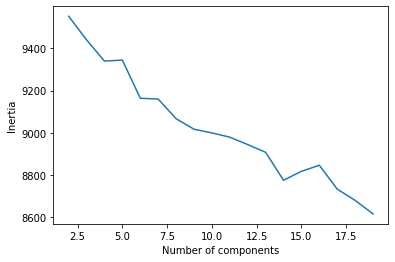

In [29]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

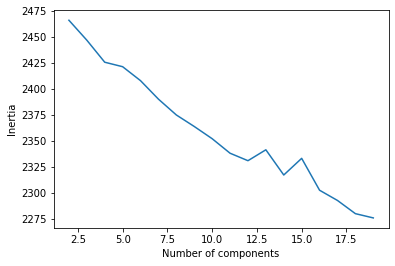

In [30]:
inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

## LDA with TF IDF 

In [31]:
def plot_top_words(model, feature_names, n_top_words, title, i, j):
    fig, axes = plt.subplots(j, i, figsize=(20, 3*j), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}")
        ax.invert_yaxis()
        ax.tick_params(axis="both",labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

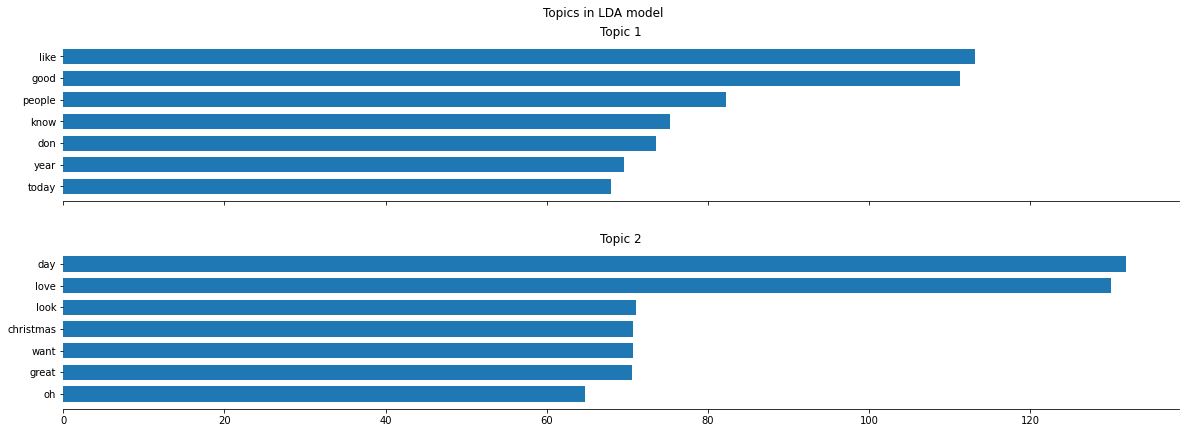

In [32]:
n_top_words = 7

def do_lda_and_plot(n_components, data):
    lda = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=5,
        learning_method="online",
        learning_offset=50.0,
    )
    lda.fit(data)

    tf_feature_names = vectorizer2.get_feature_names_out()
    plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model", 1, n_components)

do_lda_and_plot(2, tweet_text_count_train)

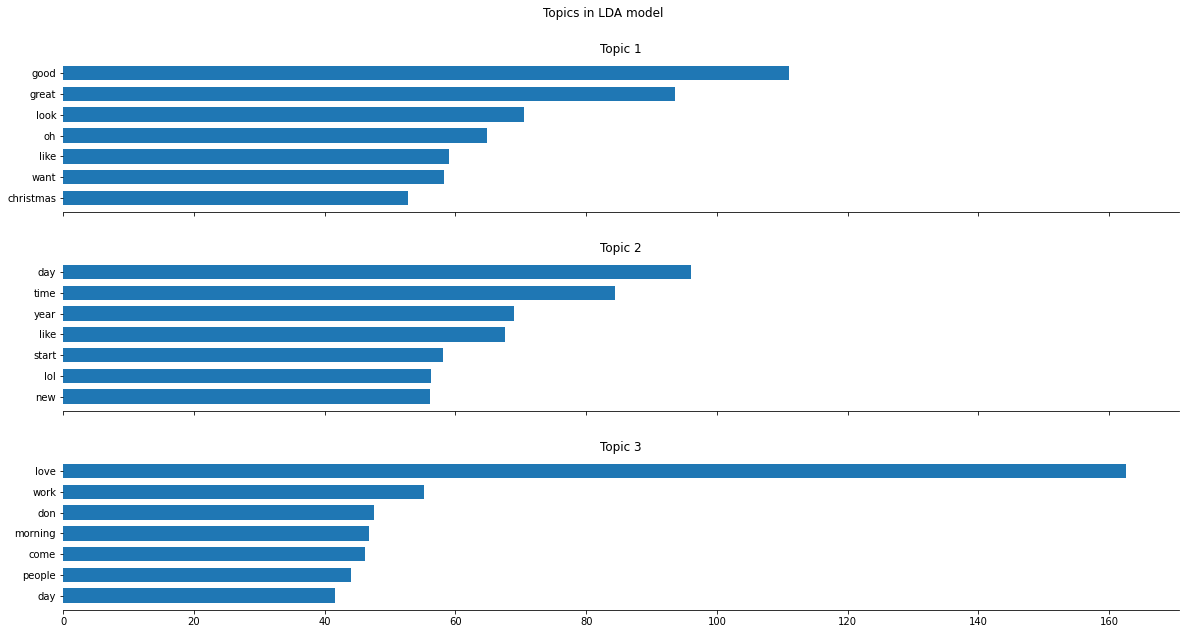

In [33]:
do_lda_and_plot(3, tweet_text_count_train)

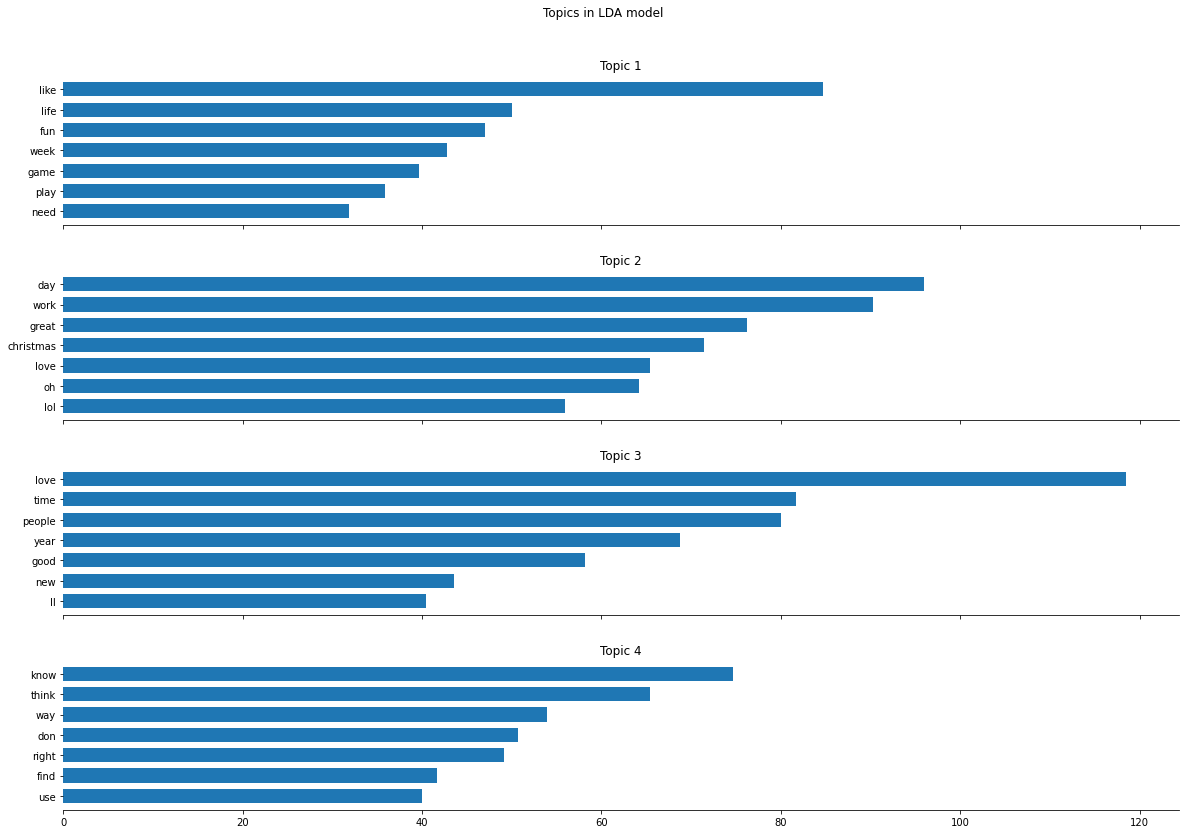

In [34]:
do_lda_and_plot(4, tweet_text_count_train)

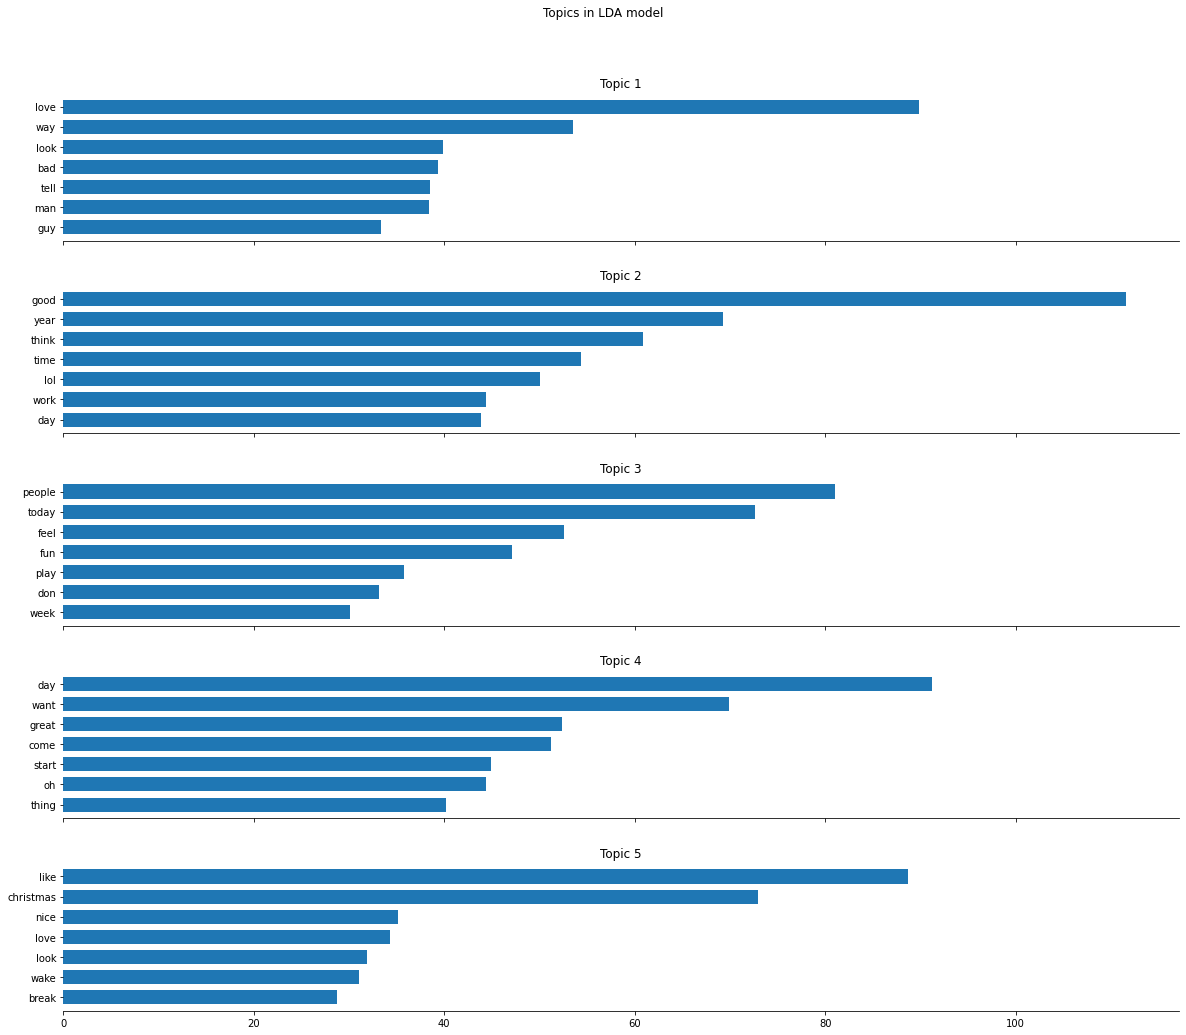

In [35]:
do_lda_and_plot(5, tweet_text_count_train)

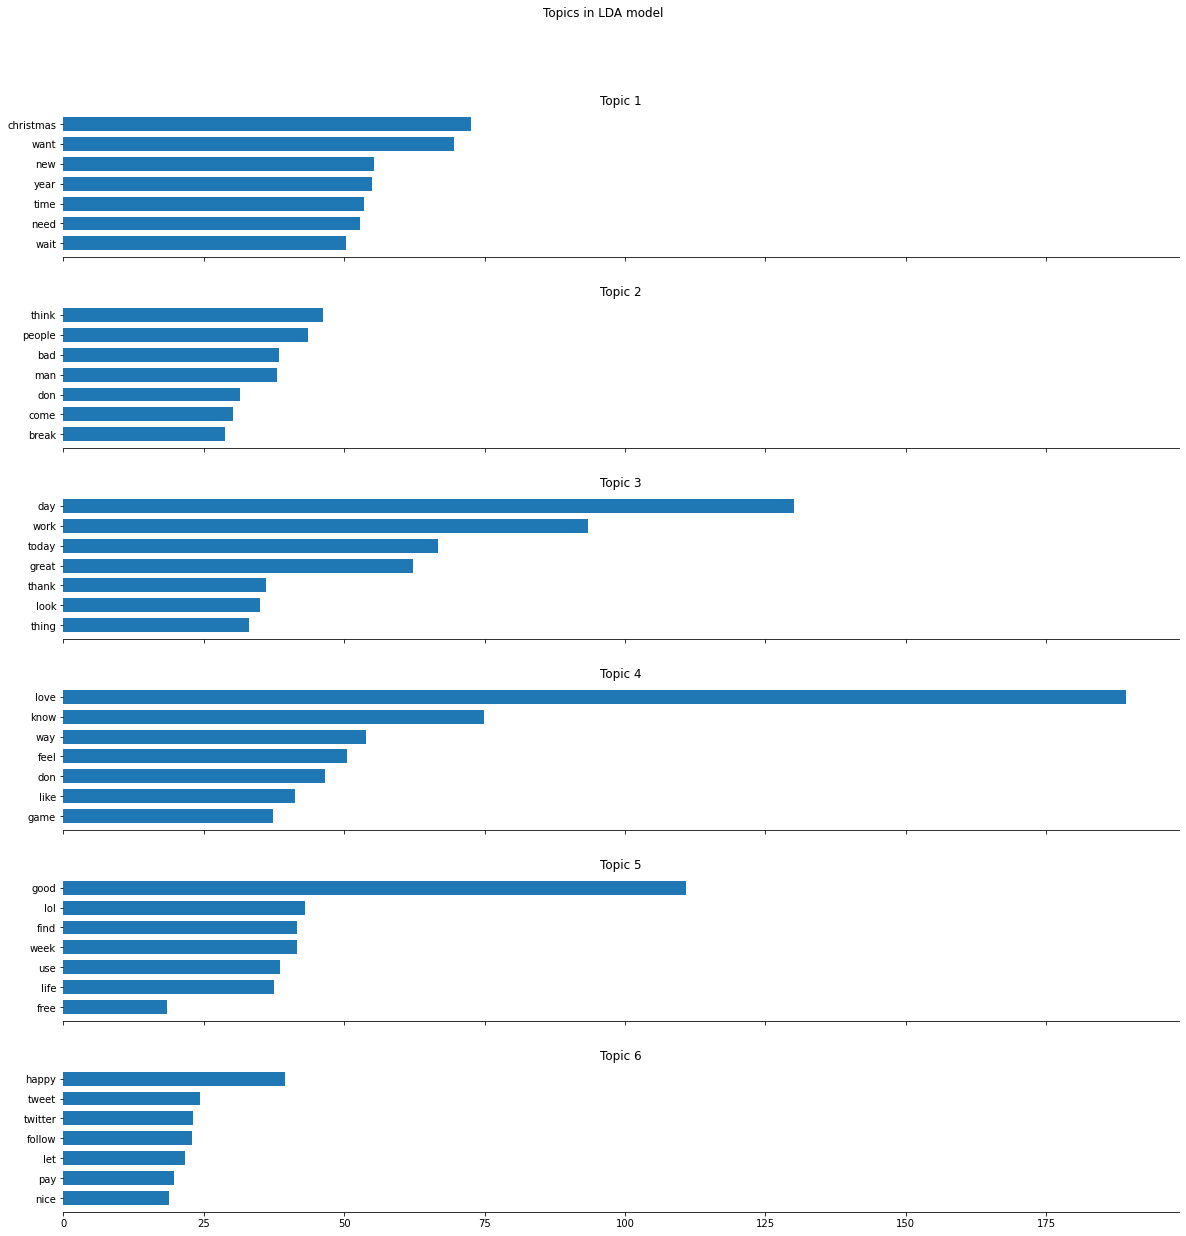

In [36]:
do_lda_and_plot(6, tweet_text_count_train)

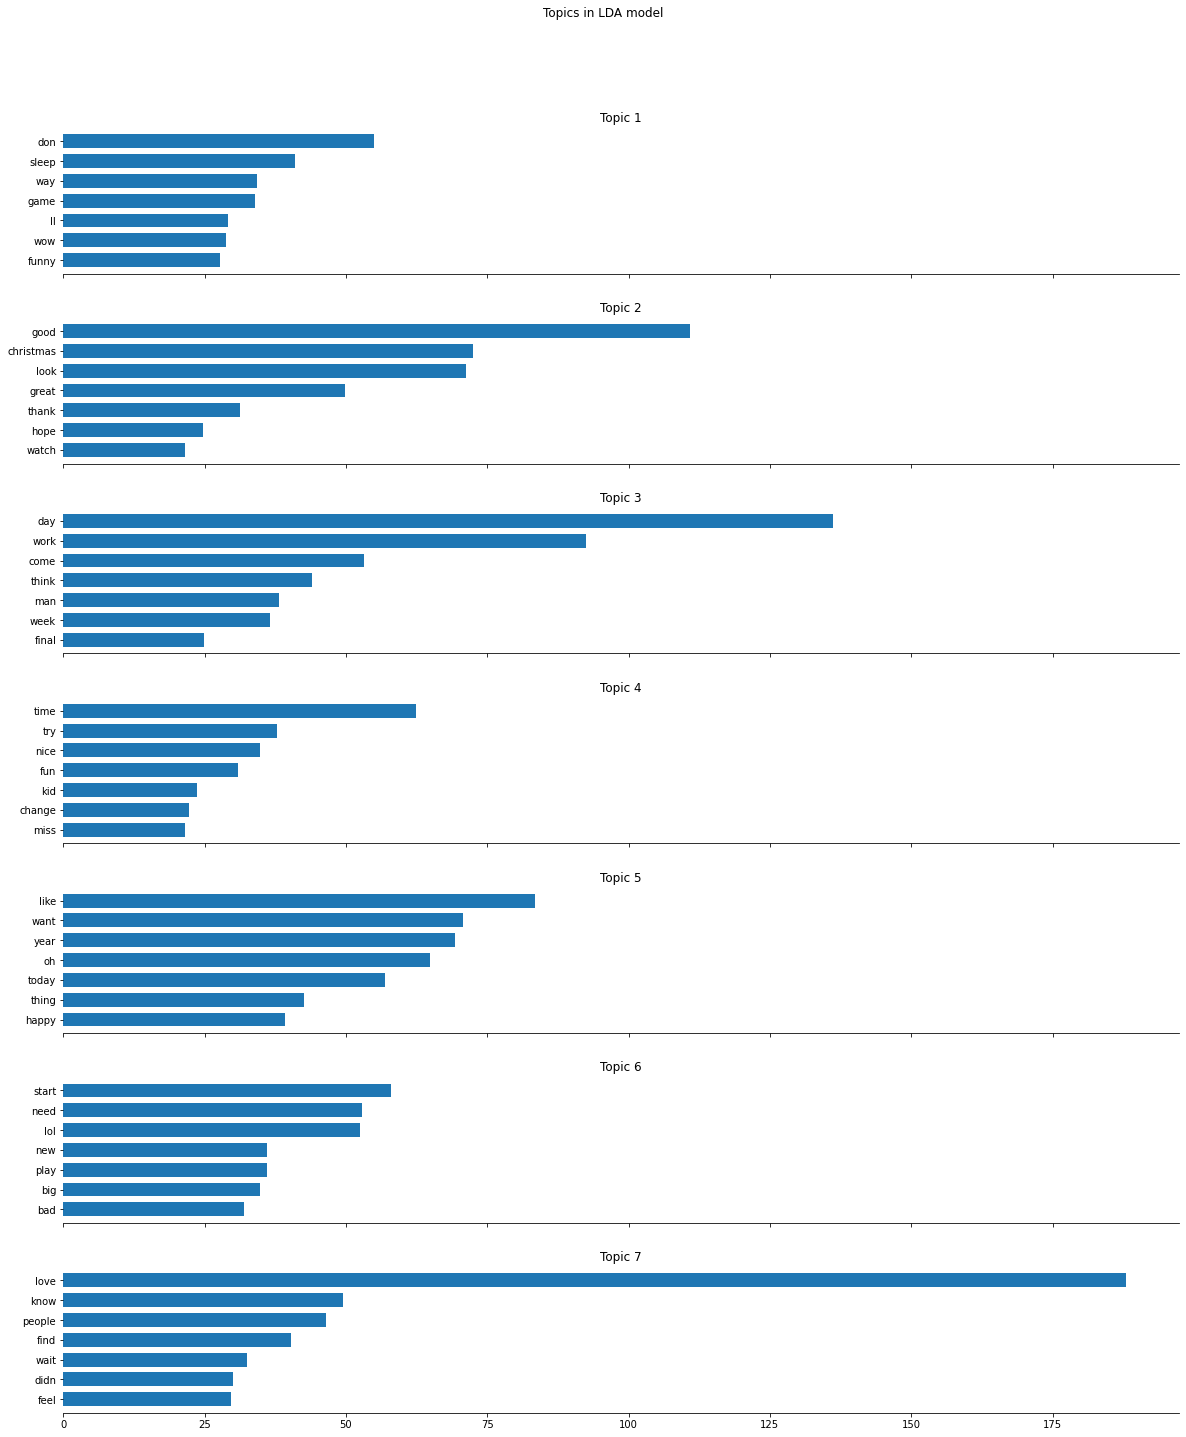

In [37]:
do_lda_and_plot(7, tweet_text_count_train)

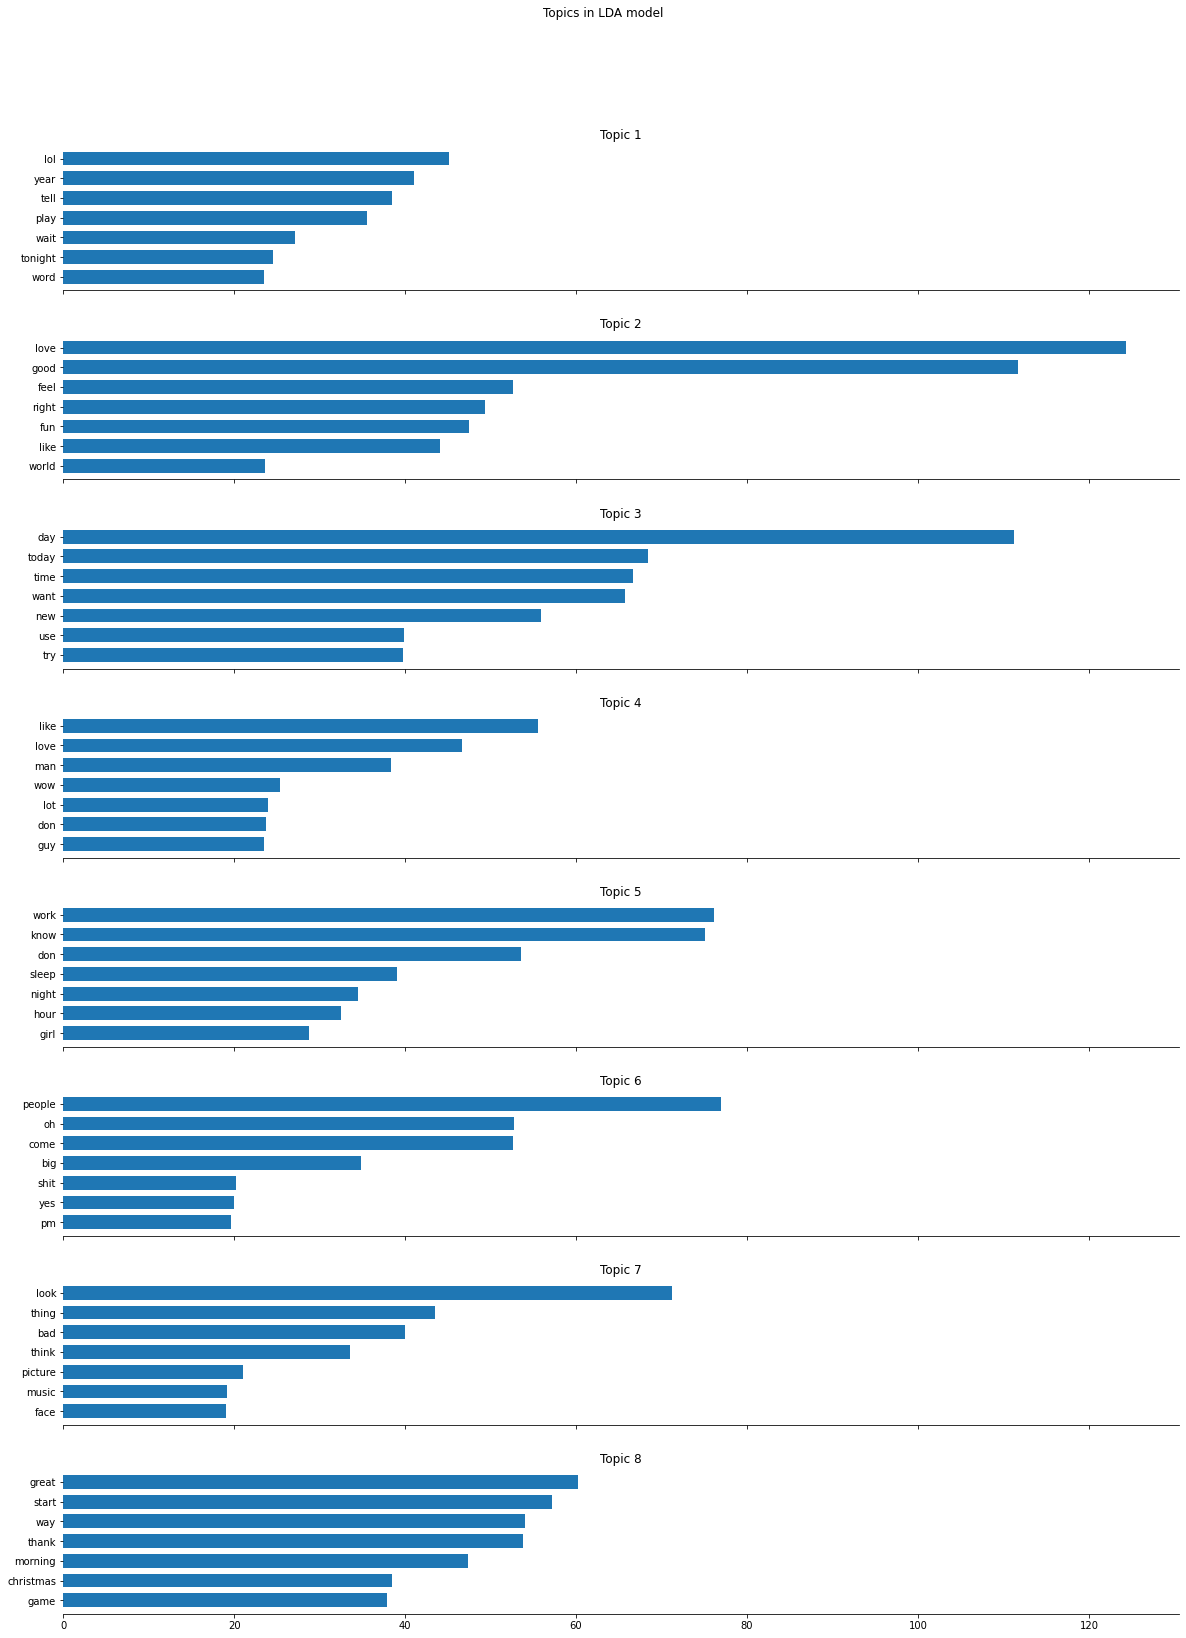

In [38]:
do_lda_and_plot(8, tweet_text_count_train)

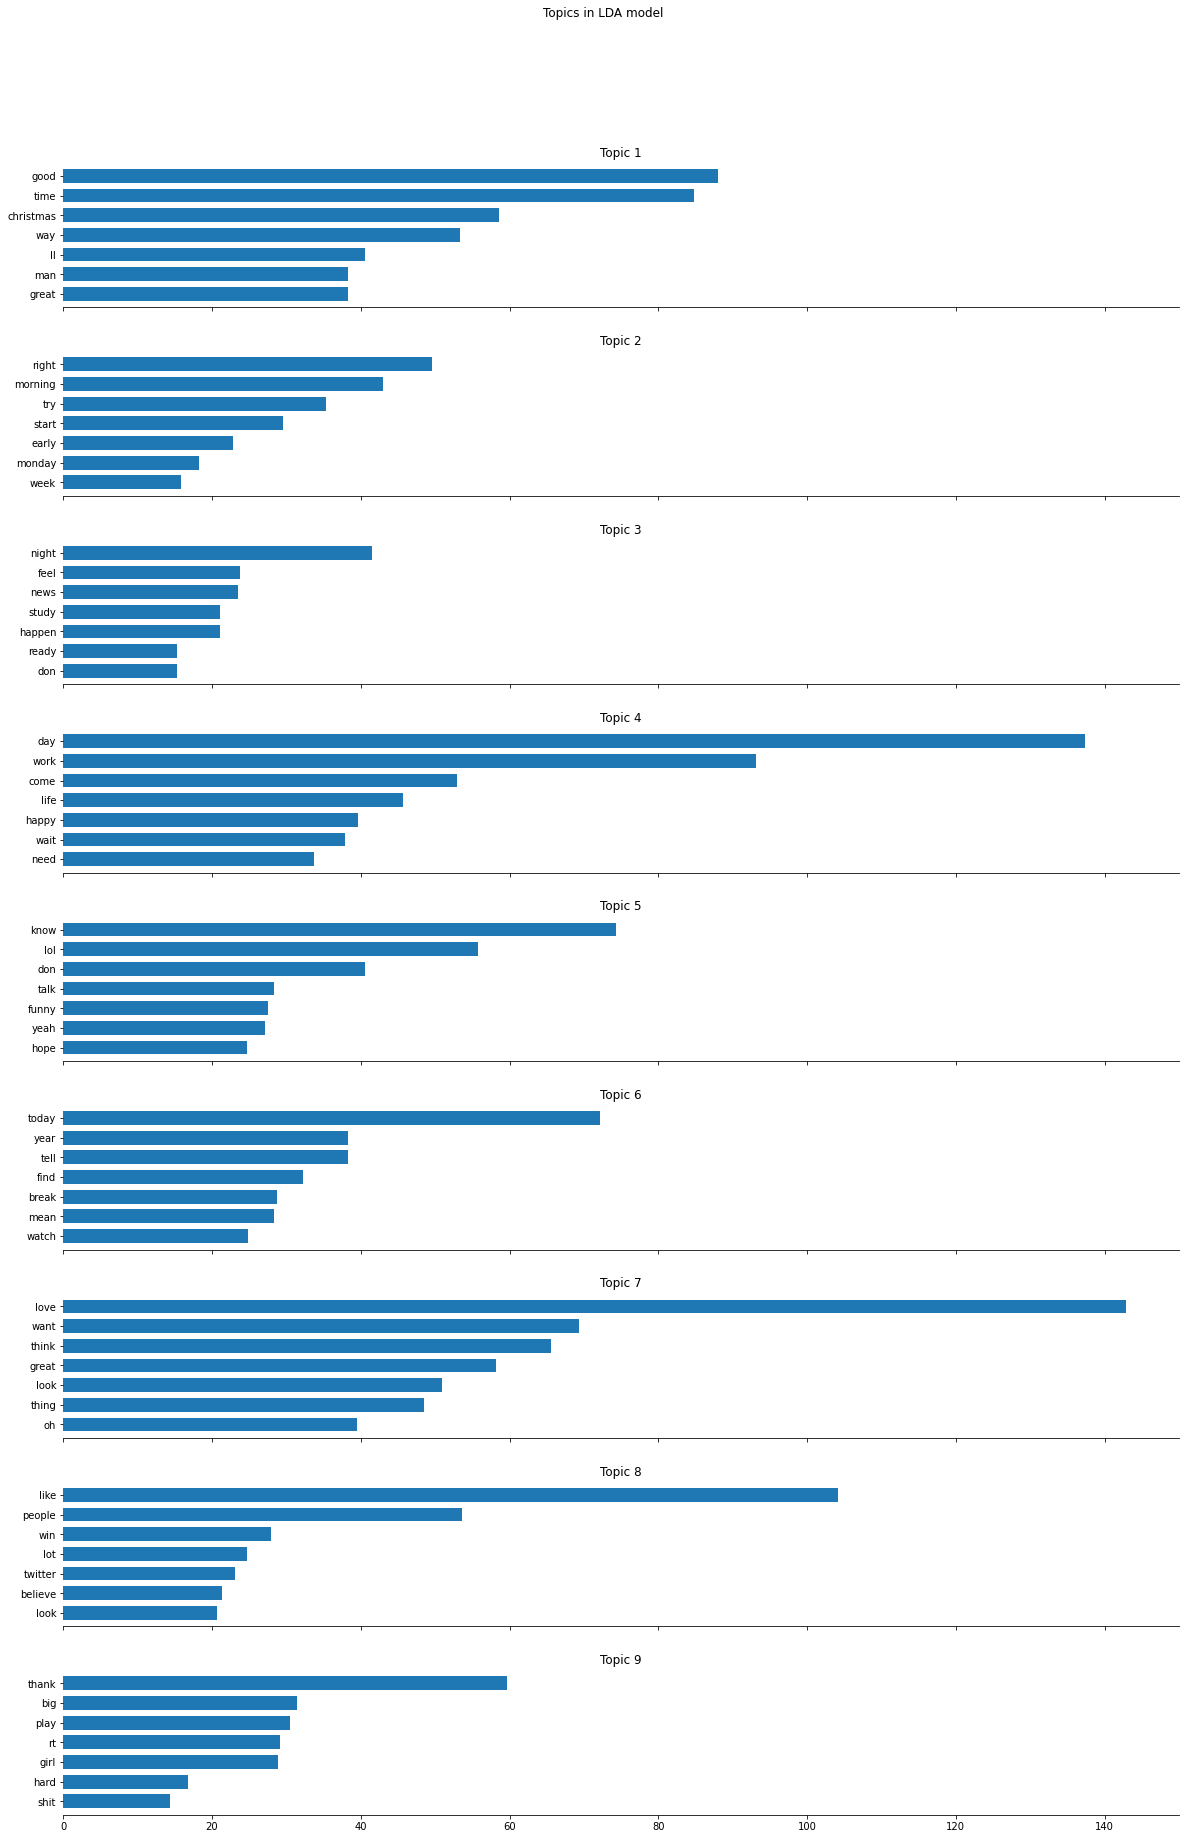

In [39]:
do_lda_and_plot(9, tweet_text_count_train)

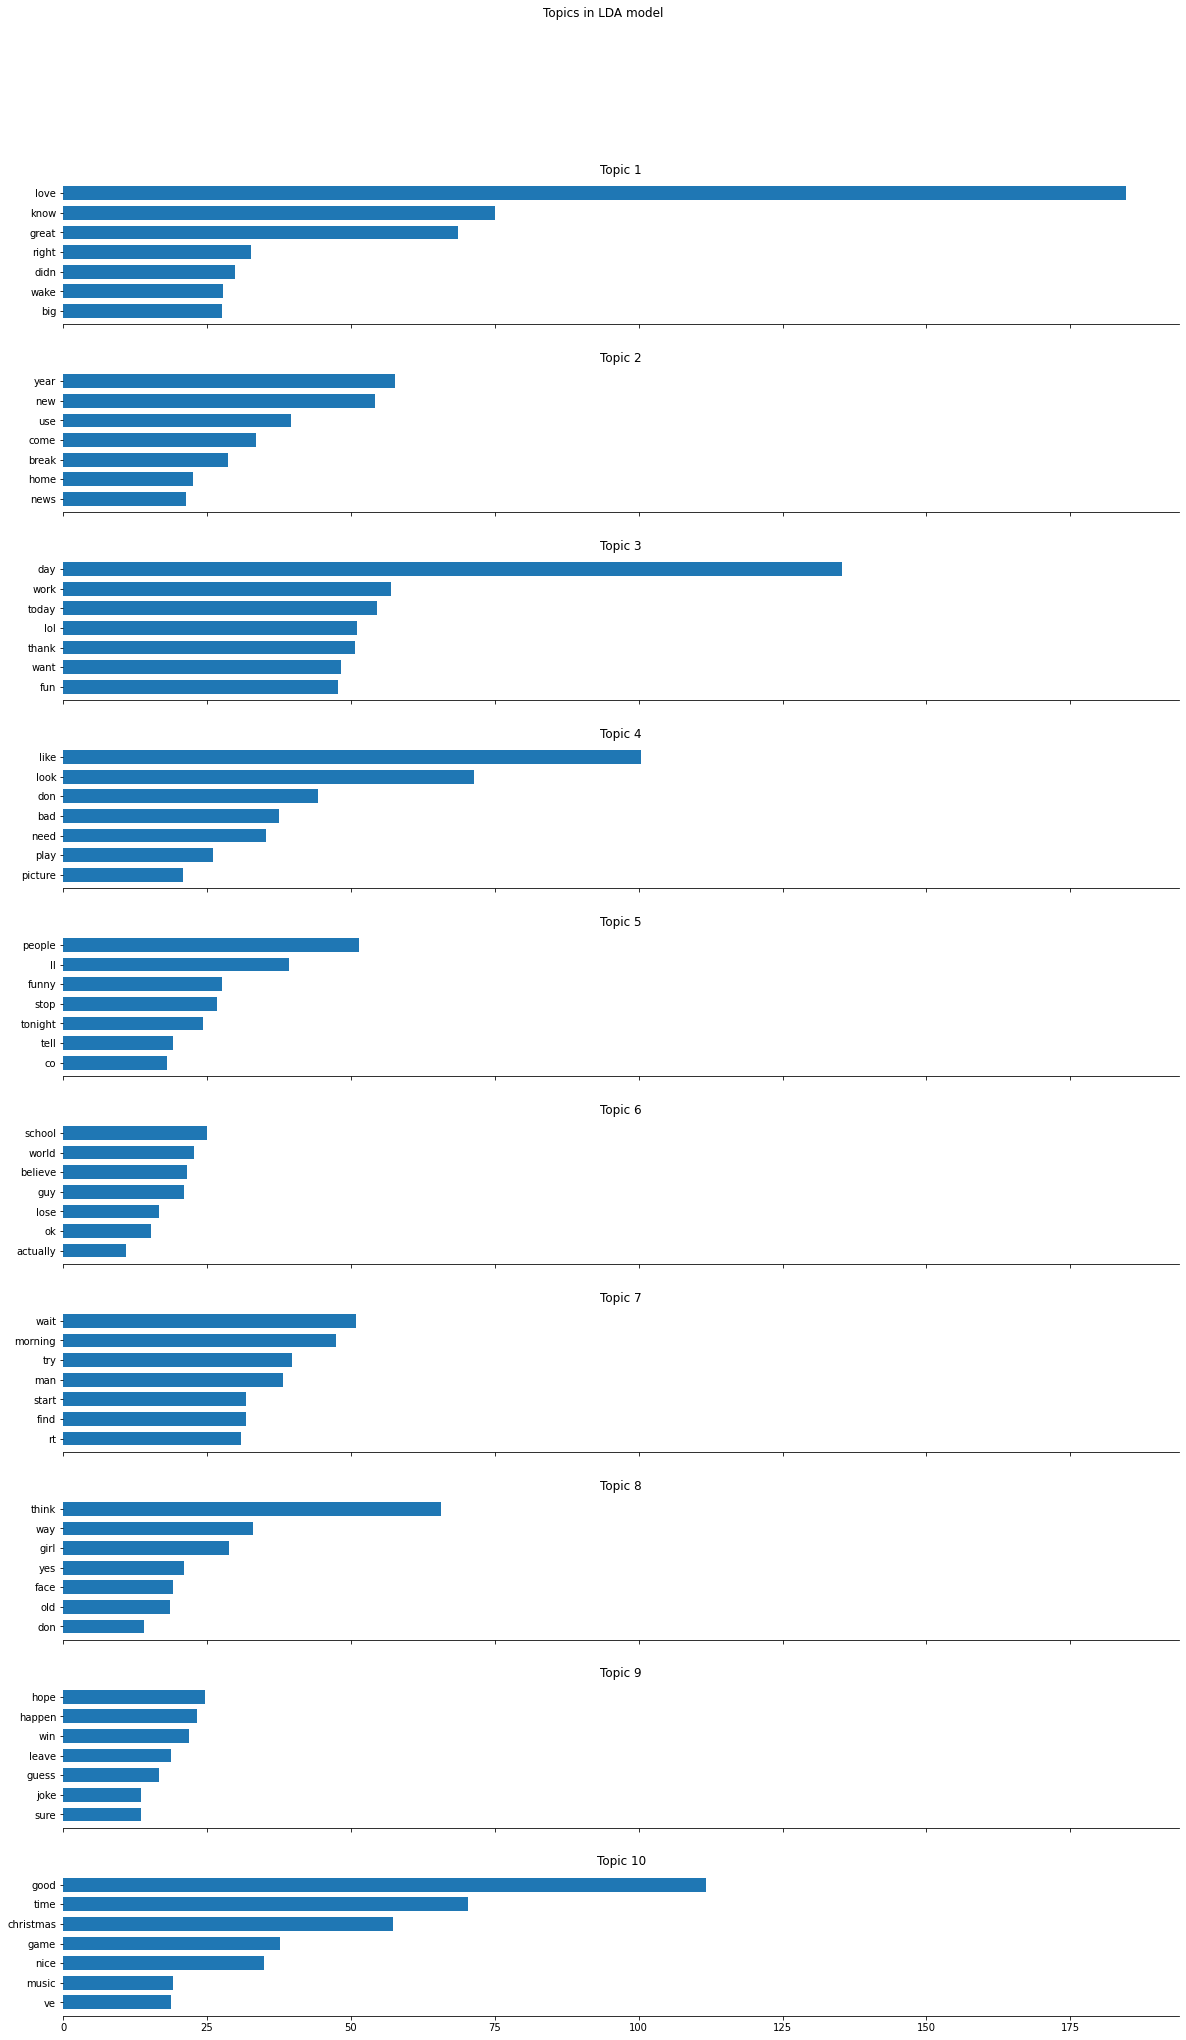

In [40]:
do_lda_and_plot(10, tweet_text_count_train)

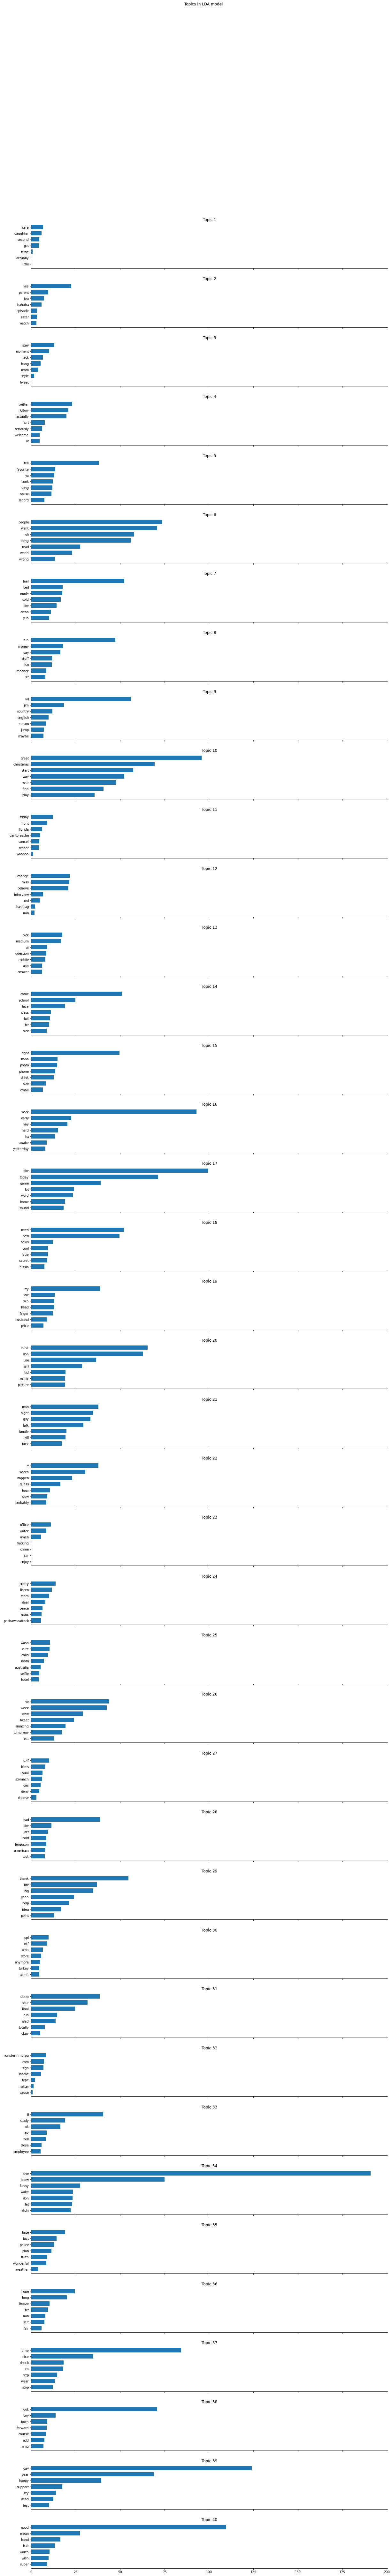

In [66]:
do_lda_and_plot(40, tweet_text_count_train)

## Embedding

In [41]:
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe

In [42]:
tweet_embedding_train = df_train[['clean_text', 'Label']]
tweet_embedding_validation = df_validation[['clean_text', 'Label']]

In [43]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)

In [44]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=5)

TWEET = Field('clean_text', pretokenize_hooks=[str.lower], numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(tweet_embedding_train, fields)
validation = TabularDataset.from_pandas(tweet_embedding_validation, fields)
train.finalize_fields()

glove = GloVe()
# Load only the vectors of vocab words.
embeddings = glove.load_vocab(vocab)

# Generate padded batch.
train_batch = train.batch(add_padding=True)
test_batch = validation.batch(add_padding=True)

In [45]:
train_batch['clean_text'].astype(int)

array([[ 40,   3, 342, ...,   1,   1,   1],
       [273, 175, 209, ...,   1,   1,   1],
       [  0,   0, 274, ...,   1,   1,   1],
       ...,
       [  5,   0, 296, ...,   1,   1,   1],
       [ 11, 587,   0, ...,   1,   1,   1],
       [  0,   0, 186, ...,   1,   1,   1]])

In [46]:
tweet_train = embeddings[train_batch['clean_text'].astype(int)]
tweet_test = embeddings[test_batch['clean_text'].astype(int)]
# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)
# Median
tweet_train_median = np.median(tweet_train, axis=1)
tweet_test_median = np.median(tweet_test, axis=1)
# Variance
tweet_train_std = tweet_train.std(axis=1)
tweet_test_std = tweet_test.std(axis=1)

In [47]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
tweet_embedding_train = pd.merge(tweet_embedding_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
tweet_embedding_test = pd.merge(tweet_embedding_validation, embeddings_test_mean_df, left_index=True, right_index=True)

In [48]:
tweet_embedding_test

,clean_text,Label,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,Sweet United Nations video. Just in time for C...,1,-0.389287,1.025143,-0.240799,-0.138176,-0.084203,-0.216682,-0.499293,-0.101789,...,-1.001789,-0.071430,-0.914875,-0.034214,0.273584,0.022289,-0.391179,-0.085138,0.272314,0.187443
1,We are rumored to have talked to Erv's agent.....,1,-0.270103,0.799918,-0.221254,-0.234780,-0.100362,-0.236409,-0.466835,0.051007,...,-0.799879,-0.055926,-0.670108,-0.094279,0.296750,0.032357,-0.373272,-0.046302,0.085054,0.151572
2,You're never too old for Footie Pajamas. http:...,0,-0.429570,1.088047,-0.232119,-0.059919,-0.096658,-0.190633,-0.457900,-0.187024,...,-1.018097,-0.153170,-0.993303,0.065515,0.203346,-0.026917,-0.351280,-0.137136,0.410343,0.258744
3,Nothing makes me happier then getting on the h...,1,-0.305719,0.828184,-0.201792,-0.130443,-0.092802,-0.164157,-0.437826,-0.074330,...,-0.795863,-0.086386,-0.771838,-0.013930,0.217305,0.002303,-0.292845,-0.091662,0.220095,0.187634
4,"But instead, I'm scrolling through Facebook, I...",0,-0.324263,0.883571,-0.197260,-0.158849,-0.046898,-0.185843,-0.462670,-0.058752,...,-0.906919,-0.057371,-0.833106,-0.053851,0.262689,0.066430,-0.364835,-0.066389,0.129780,0.157357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,Only ones in the cinema http://t.co/qeid3NXXTs,0,-0.475952,1.135583,-0.268522,-0.029632,-0.118567,-0.133944,-0.497134,-0.220382,...,-1.051946,-0.154170,-1.026642,0.088848,0.183336,-0.024603,-0.360823,-0.151144,0.479270,0.218176
1141,years ago in M && S in Rochdale they had 2 lef...,1,-0.269474,0.754282,-0.204723,-0.293217,-0.063209,-0.263304,-0.464698,0.079172,...,-0.804307,0.008909,-0.643707,-0.180282,0.349719,0.160608,-0.338969,-0.061818,-0.005793,0.101707
1142,I retweeted this so Chris Graham blocked me. |...,1,-0.393986,1.013655,-0.236689,-0.136323,-0.082062,-0.210957,-0.492635,-0.102657,...,-0.984255,-0.079826,-0.920012,-0.038687,0.269185,-0.002726,-0.387570,-0.088857,0.294265,0.196650
1143,I'm glad the DC Council has it's priorities in...,1,-0.396030,1.026793,-0.237844,-0.093634,-0.068095,-0.159045,-0.505740,-0.126043,...,-0.975101,-0.092947,-0.950554,0.035942,0.225089,-0.009225,-0.355263,-0.104330,0.339493,0.185910


In [49]:
from sklearn.linear_model import LogisticRegression
X_ = tweet_embedding_train[[x for x in range(300)]]
y_ = tweet_embedding_train['Label']
clf = LogisticRegression(solver='liblinear', C=4.16, penalty='l1').fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_test = tweet_embedding_test[[x for x in range(300)]]
y_test = tweet_embedding_test['Label']
print(clf.score(X_test, y_test))

Train score
0.6197604790419161
Validation score
0.5703056768558952


In [50]:
## Features
## Broj neg rijeci
## Broj poz rijeci
## Omjer
## Udaljenost izmedu poz i neg rijeci

### KMeans using embeddings

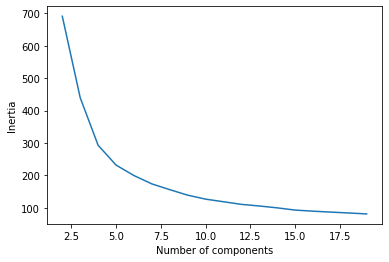

In [51]:
# 3 ili 5

inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(X_)
    inertia.append(model.inertia_)
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

Potrebno dodatno preprocesat da samo rjeci ostanu

In [52]:
import nltk
# nltk.download('vader_lexicon') # if error run this

In [53]:
from nltk.sentiment import SentimentIntensityAnalyzer
import copy

def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['clean_text']) > 0:
            doc = nlp(row['clean_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(copy.copy(current_neg))
            neg_word_count.append(copy.copy(len(current_neg)))
            pos_words.append(copy.copy(current_pos))
            pos_word_count.append(copy.copy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [54]:
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text
398,399,1,About to write my math final really excited #...,84,9,0,1,1,10,0,0,About to write my math final really excited ht...
2403,2407,0,Pretty sure there's a satanic baby in the apar...,134,21,0,1,0,22,0,0,Pretty sure there's a satanic baby in the apar...
2179,2183,0,[Alaska #HipHop] Flowtronics: What's This Worl...,133,15,1,1,1,17,0,0,[Alaska Flowtronics: What's This World Coming ...
3383,3398,1,People in this school seem to amaze me..,41,8,0,0,0,8,0,0,People in this school seem to amaze me..
50,51,1,It will be impossible for me to be late if I s...,101,17,0,3,0,20,0,0,It will be impossible for me to be late if I s...
...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1130,1,@Zoopla brilliant news for potential young buy...,51,6,1,0,0,7,1,0,brilliant news for potential young buyers!
1213,1214,1,I'm seeing more and more people using the term...,133,23,0,1,0,24,0,0,I'm seeing more and more people using the term...
490,491,1,I couldnt help myself.. I am a bad person... ...,68,10,0,0,1,10,0,0,I couldnt help myself.. I am a bad person... h...
1485,1486,0,My Com professor keeps talking about Twitter. ...,51,8,0,0,0,8,0,0,My Com professor keeps talking about Twitter. ...


In [55]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)

In [56]:
df_train['neg_word_count'] = neg_word_count_train
df_train['neg_word'] = neg_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['pos_word'] = pos_words_train
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text,neg_word_count,neg_word,pos_word_count,pos_word
398,399,1,About to write my math final really excited #...,84,9,0,1,1,10,0,0,About to write my math final really excited ht...,0,[],1,[excited]
2403,2407,0,Pretty sure there's a satanic baby in the apar...,134,21,0,1,0,22,0,0,Pretty sure there's a satanic baby in the apar...,2,"[cry, ugh]",2,"[pretty, sure]"
2179,2183,0,[Alaska #HipHop] Flowtronics: What's This Worl...,133,15,1,1,1,17,0,0,[Alaska Flowtronics: What's This World Coming ...,0,[],0,[]
3383,3398,1,People in this school seem to amaze me..,41,8,0,0,0,8,0,0,People in this school seem to amaze me..,0,[],1,[amaze]
50,51,1,It will be impossible for me to be late if I s...,101,17,0,3,0,20,0,0,It will be impossible for me to be late if I s...,0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1130,1,@Zoopla brilliant news for potential young buy...,51,6,1,0,0,7,1,0,brilliant news for potential young buyers!,0,[],1,[brilliant]
1213,1214,1,I'm seeing more and more people using the term...,133,23,0,1,0,24,0,0,I'm seeing more and more people using the term...,0,[],0,[]
490,491,1,I couldnt help myself.. I am a bad person... ...,68,10,0,0,1,10,0,0,I couldnt help myself.. I am a bad person... h...,1,[bad],1,[help]
1485,1486,0,My Com professor keeps talking about Twitter. ...,51,8,0,0,0,8,0,0,My Com professor keeps talking about Twitter. ...,0,[],0,[]


In [57]:
df_validation['neg_word_count'] = neg_word_count_val
df_validation['neg_word'] = neg_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['pos_word'] = pos_words_val

In [58]:
from sklearn.linear_model import LogisticRegression
X_ = df_train[['neg_word_count', 'pos_word_count']]
y_ = df_train['Label']
clf = LogisticRegression(random_state=0).fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[['neg_word_count', 'pos_word_count']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

Train score
0.5864520958083832
Validation score
0.6148471615720524


In [59]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        And all I wanna do is blast music and get read...
pos_word                                       [ready, considerate]
pos_word_count                                                    2
neg_word                                                   [suffer]
neg_word_count                                                    1
Name: 1674, dtype: object

In [60]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(copy.copy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [61]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)

In [62]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text,neg_word_count,neg_word,pos_word_count,pos_word,pos_neg_within_5
398,399,1,About to write my math final really excited #...,84,9,0,1,1,10,0,0,About to write my math final really excited ht...,0,[],1,[excited],0
2403,2407,0,Pretty sure there's a satanic baby in the apar...,134,21,0,1,0,22,0,0,Pretty sure there's a satanic baby in the apar...,2,"[cry, ugh]",2,"[pretty, sure]",0
2179,2183,0,[Alaska #HipHop] Flowtronics: What's This Worl...,133,15,1,1,1,17,0,0,[Alaska Flowtronics: What's This World Coming ...,0,[],0,[],0
3383,3398,1,People in this school seem to amaze me..,41,8,0,0,0,8,0,0,People in this school seem to amaze me..,0,[],1,[amaze],0
50,51,1,It will be impossible for me to be late if I s...,101,17,0,3,0,20,0,0,It will be impossible for me to be late if I s...,0,[],0,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1130,1,@Zoopla brilliant news for potential young buy...,51,6,1,0,0,7,1,0,brilliant news for potential young buyers!,0,[],1,[brilliant],0
1213,1214,1,I'm seeing more and more people using the term...,133,23,0,1,0,24,0,0,I'm seeing more and more people using the term...,0,[],0,[],0
490,491,1,I couldnt help myself.. I am a bad person... ...,68,10,0,0,1,10,0,0,I couldnt help myself.. I am a bad person... h...,1,[bad],1,[help],0
1485,1486,0,My Com professor keeps talking about Twitter. ...,51,8,0,0,0,8,0,0,My Com professor keeps talking about Twitter. ...,0,[],0,[],0


In [63]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']
clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

Train score
0.5142215568862275
Validation score
0.503056768558952


In [64]:
within_5_val

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
